# Text preprocessing

In [13]:
DATA = "data/"
TRAIN = f"{DATA}/train.csv"
TEST = f"{DATA}/test.csv"
TRAIN_LABEL = f"{DATA}/train_label.txt"
TRAIN_TITLE = f"{DATA}/train_title.txt"
TRAIN_TEXT = f"{DATA}/train_text.txt"
TEST_LABEL = f"{DATA}/test_label.txt"
TEST_TITLE = f"{DATA}/test_title.txt"
TEST_TEXT = f"{DATA}/test_text.txt"

TRAIN_NORM = f"{DATA}/train_norm.txt"
TEST_NORM = f"{DATA}/test_norm.txt"

In [14]:
# # Spilt the csv into label, title, text
# import pandas as pd

# train = pd.read_csv(TRAIN)
# train_col = train.columns
# train[train_col[0]].to_csv(TRAIN_LABEL, index=False)
# train[train_col[1]].to_csv(TRAIN_TITLE, index=False)
# train[train_col[2]].to_csv(TRAIN_TEXT, index=False)

# test = pd.read_csv(TEST)
# test_col = test.columns
# test[test_col[0]].to_csv(TEST_LABEL, index=False)
# test[test_col[1]].to_csv(TEST_TITLE, index=False)
# test[test_col[2]].to_csv(TEST_TEXT, index=False)
# del train, test, pd

In [15]:
# from src.Normalizer import normalize_data
# normalize_data(TRAIN_TEXT, TRAIN_NORM)
# normalize_data(TEST_TEXT, TEST_NORM)

# Training skipgram model

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import DataLoader

from src.SkipGram import SkipGram, Corpus, CorpusData
from src.utils import tfb_projector, print_similar

%config InlineBackend.figure_formats = ['svg']

In [17]:
# Device Selection
if torch.backends.mps.is_available:
    device = "mps"  # OSX
elif torch.cuda.is_available:
    device = "cuda"
else:
    device = "cpu"

In [21]:
# Read The corpus, create all the training pairs
sk_corpus = Corpus(TRAIN_NORM, 2)
# Create a custom Dataset
sk_corpusdata = CorpusData(sk_corpus)
# Dataloader
sk_dataloader = DataLoader(sk_corpusdata, batch_size=4096, shuffle=True)

In [22]:
sk_corpus.total, sk_corpus.vocab_size, len(sk_corpusdata)

(1944289, 56464, 3286449)

In [23]:
# Model definition
N = sk_corpus.vocab_size
H = 256  # Embeding dimension
model = SkipGram(N, H)
model = model.to(device)

In [24]:
model, sk_log = model.train_model(sk_dataloader, 3, 1e-3, device)

Epoch 3/3: 100%|██████████| 803/803 [04:19<00:00,  3.09it/s, loss=8.81]


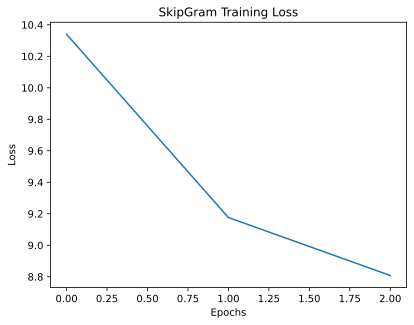

In [25]:
plt.plot(sk_log)
plt.title("SkipGram Training Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("./report/figures/sk_loss.pdf", bbox_inches='tight')
plt.show()

### Similarity research

In [26]:
idx = sk_corpus.word2id.get('google')
print_similar(model, sk_corpus, idx, 5)
print("==================================")
idx = sk_corpus.word2id.get('linux')
print_similar(model, sk_corpus, idx, 5)
print("==================================")
idx = sk_corpus.word2id.get('windows')
print_similar(model, sk_corpus, idx,5)
print("==================================")
idx = sk_corpus.word2id.get('war')
print_similar(model, sk_corpus, idx, 5)
print("==================================")
idx = sk_corpus.word2id.get('football')
print_similar(model, sk_corpus, idx, 5)
print("==================================")
idx = sk_corpus.word2id.get('food')
print_similar(model, sk_corpus, idx, 5)
print("==================================")
idx = sk_corpus.word2id.get('money')
print_similar(model, sk_corpus, idx, 5)
print("==================================")
idx = sk_corpus.word2id.get('police')
print_similar(model, sk_corpus, idx, 5)


google              :1.000
fearsomely          :0.285
cepeda              :0.274
dustin              :0.269
ohlmeyer            :0.267
linux               :1.000
emitting            :0.267
punahou             :0.266
wedged              :0.251
originated          :0.250
windows             :1.000
prebiotic           :0.275
regulated           :0.270
glossary            :0.247
ortiz               :0.238
war                 :1.000
tenants             :0.284
louisen             :0.279
mahat               :0.256
pictured            :0.253
football            :1.000
revamped            :0.279
polamalu            :0.272
eulogising          :0.265
mattress            :0.262
food                :1.000
parallel            :0.284
firecrackers        :0.279
camp                :0.267
unclaimed           :0.256
money               :1.000
aristocrats         :0.311
excavate            :0.292
hercules            :0.281
jamming             :0.280
police              :1.000
natick              :0.276
m

### Visualization with Tensor projector

In [ ]:
# Require tensorboard
tfb_projector(model, sk_corpus, "runs/vsk")

# Text Classifiers

In [12]:
import src.TextClassifier as TCl

In [13]:
word2id = sk_corpus.word2id
texts = TCl.CorpusClassifier(
    f"{DATA}/train_norm.txt", f"{DATA}/train_label.txt", word2id
)
textsdata = TCl.ClassifierData(texts)
textsloader = TCl.dataLoader(textsdata, 8192)

In [14]:
embedding = model.vEmbedding
classf = TCl.TextClassifier(4, embedding, False)
classf = classf.to(device)

In [15]:
classf, tc_log = classf.train_classifier(textsloader, 20, 1e-2, device)

Epoch 20: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s, accuracy=0.94, loss=0.17]


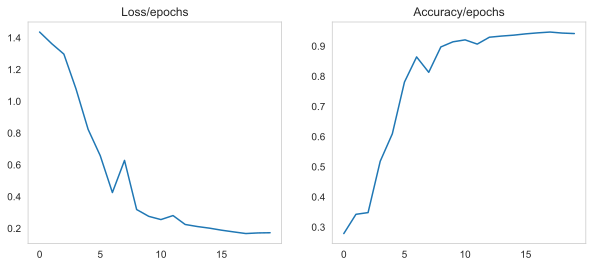

In [16]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(tc_log[:, 0])
plt.title("Loss/epochs")
plt.grid()
plt.subplot(122)
plt.plot(tc_log[:, 1])
plt.title("Accuracy/epochs")
plt.grid()
plt.show()

# Testing Data

In [17]:
test_texts = TCl.CorpusClassifier(
    f"{DATA}/test_norm.txt", f"{DATA}/test_label.txt", word2id
)
test_textsdata = TCl.ClassifierData(test_texts)
test_textsloader = TCl.dataLoader(test_textsdata, 4096)

In [18]:
loss, acc, conf_matrix = classf.eval_classifier(test_textsloader, device)

Eval: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it, accuracy=0.89, loss=0.35]


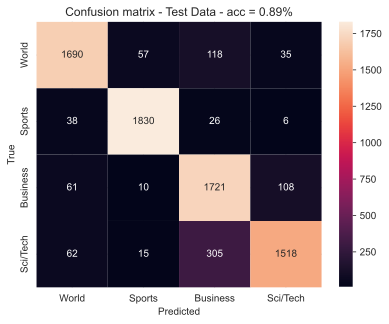

In [19]:
labels = ("World", "Sports", "Business", "Sci/Tech")
sns.heatmap(conf_matrix, annot=True, fmt=f".0f")
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels)
plt.title(fr"Confusion matrix - Test Data - acc = {acc:.2f}%")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()